In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from scipy.io import loadmat
from PIL import Image, ImageDraw, ImageFont
from matplotlib.patches import Rectangle

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random

from collections import Counter

In [2]:
import cv2
import matplotlib.pyplot as plt 
from IPython.core.pylabtools import figsize

In [3]:
PATH = Path('data')
os.listdir(PATH)

['test_images',
 'train_adj.csv',
 '.DS_Store',
 'unicode_translation.csv',
 'Osaka.ttc',
 'train.csv',
 'train_images',
 'sample_submission.csv']

In [4]:
train_path = Path(PATH/'train_images')
test_path = Path(PATH/'test_images')

### Load Labels

In [5]:
labels = pd.read_csv('data/unicode_translation.csv')
labels.head()

,Unicode,char
0,U+0031,1
1,U+0032,2
2,U+0034,4
3,U+0036,6
4,U+0039,9


In [6]:
labels_dict = {labels.Unicode.values[i]: labels.char.values[i] 
               for i in range(len(labels))}
labels_dict['U+0031']

'1'

### Load Train Sets

In [14]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [10]:
df_train.loc[0]['labels']

'U+306F 1231 3465 133 53 U+304C 275 1652 84 69 U+3044 1495 1218 143 69 U+3051 220 3331 53 91 U+306B 911 1452 61 92 U+306B 927 3445 71 92 U+306E 904 2879 95 92 U+5DE5 1168 1396 187 95 U+3053 289 3166 69 97 U+4E09 897 3034 121 107 U+306E 547 1912 141 108 U+3084 1489 2675 151 109 U+3068 1561 2979 55 116 U+5DF1 1513 2500 127 117 U+3082 1213 1523 72 119 U+3055 1219 3266 95 124 U+306E 259 2230 68 125 U+306E 1184 2423 169 125 U+4E16 849 2236 163 127 U+7D30 1144 1212 200 128 U+305D 316 3287 57 133 U+4EBA 217 2044 183 135 U+3051 277 2974 112 137 U+308C 201 3423 181 137 U+3060 243 2830 159 143 U+5F37 1479 2034 163 145 U+306E 1497 1567 123 152 U+305F 1164 952 145 153 U+3066 552 1199 97 155 U+4FF3 537 2095 176 155 U+6839 203 1439 184 156 U+304B 1188 2606 156 157 U+8AE7 549 2328 156 159 U+308C 1495 2784 168 159 U+5B50 891 1255 100 164 U+3092 584 2546 117 164 U+53CA 849 1588 151 164 U+8005 1192 2198 133 169 U+305A 889 1763 103 171 U+907F 513 945 181 171 U+6B63 539 1439 136 172 U+6587 192 2382 216 17

Use spark to re-adjust `train.csv`

In [31]:
import pyspark
sc = pyspark.SparkContext.getOrCreate()

In [32]:
train_rdd = sc.textFile('data/train.csv')
train_rdd.take(2)

['image_id,labels',
 '100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 U+3044 1495 1218 143 69 U+3051 220 3331 53 91 U+306B 911 1452 61 92 U+306B 927 3445 71 92 U+306E 904 2879 95 92 U+5DE5 1168 1396 187 95 U+3053 289 3166 69 97 U+4E09 897 3034 121 107 U+306E 547 1912 141 108 U+3084 1489 2675 151 109 U+3068 1561 2979 55 116 U+5DF1 1513 2500 127 117 U+3082 1213 1523 72 119 U+3055 1219 3266 95 124 U+306E 259 2230 68 125 U+306E 1184 2423 169 125 U+4E16 849 2236 163 127 U+7D30 1144 1212 200 128 U+305D 316 3287 57 133 U+4EBA 217 2044 183 135 U+3051 277 2974 112 137 U+308C 201 3423 181 137 U+3060 243 2830 159 143 U+5F37 1479 2034 163 145 U+306E 1497 1567 123 152 U+305F 1164 952 145 153 U+3066 552 1199 97 155 U+4FF3 537 2095 176 155 U+6839 203 1439 184 156 U+304B 1188 2606 156 157 U+8AE7 549 2328 156 159 U+308C 1495 2784 168 159 U+5B50 891 1255 100 164 U+3092 584 2546 117 164 U+53CA 849 1588 151 164 U+8005 1192 2198 133 169 U+305A 889 1763 103 171 U+907F 513 945 181 171 U+6B63 

In [39]:
# Get column
cols = train_rdd.take(1)[0].split(',')
cols

['image_id', 'labels']

In [34]:
# Get data
data_rdd = train_rdd.filter(lambda x: 'image_id' not in x)\
                    .map(lambda x: x.split(','))
data_rdd.take(1)

[['100241706_00004_2',
  'U+306F 1231 3465 133 53 U+304C 275 1652 84 69 U+3044 1495 1218 143 69 U+3051 220 3331 53 91 U+306B 911 1452 61 92 U+306B 927 3445 71 92 U+306E 904 2879 95 92 U+5DE5 1168 1396 187 95 U+3053 289 3166 69 97 U+4E09 897 3034 121 107 U+306E 547 1912 141 108 U+3084 1489 2675 151 109 U+3068 1561 2979 55 116 U+5DF1 1513 2500 127 117 U+3082 1213 1523 72 119 U+3055 1219 3266 95 124 U+306E 259 2230 68 125 U+306E 1184 2423 169 125 U+4E16 849 2236 163 127 U+7D30 1144 1212 200 128 U+305D 316 3287 57 133 U+4EBA 217 2044 183 135 U+3051 277 2974 112 137 U+308C 201 3423 181 137 U+3060 243 2830 159 143 U+5F37 1479 2034 163 145 U+306E 1497 1567 123 152 U+305F 1164 952 145 153 U+3066 552 1199 97 155 U+4FF3 537 2095 176 155 U+6839 203 1439 184 156 U+304B 1188 2606 156 157 U+8AE7 549 2328 156 159 U+308C 1495 2784 168 159 U+5B50 891 1255 100 164 U+3092 584 2546 117 164 U+53CA 849 1588 151 164 U+8005 1192 2198 133 169 U+305A 889 1763 103 171 U+907F 513 945 181 171 U+6B63 539 1439 136 1

The second element in a row has multiple sets of Unicode character, X, Y, Width, and Height.

In [64]:
# Number of Rows
data_rdd.count() 

3881

In [66]:
# Number of Rows with questionable record in labels
data_rdd.filter(lambda x: len(x[1].split(' ')) % 5 != 0).count()

276

In [69]:
# Seems all the questionable records have no labels at all
data_rdd.filter(lambda x: len(x[1].split(' ')) % 5 != 0).collect()

[['100241706_00038_2', ''],
 ['100241706_00039_1', ''],
 ['100241706_00039_2', ''],
 ['100241706_00040_1', ''],
 ['100249371_00003_2', ''],
 ['100249371_00004_1', ''],
 ['100249371_00018_2', ''],
 ['100249371_00030_2', ''],
 ['100249371_00048_1', ''],
 ['100249376_00002_1', ''],
 ['100249376_00003_1', ''],
 ['100249376_00003_2', ''],
 ['100249376_00056_1', ''],
 ['100249376_00057_1', ''],
 ['100249416_00002_1', ''],
 ['100249416_00008_2', ''],
 ['100249416_00009_1', ''],
 ['100249416_00010_2', ''],
 ['100249416_00013_2', ''],
 ['100249416_00023_2', ''],
 ['100249416_00026_2', ''],
 ['100249476_00002_1', ''],
 ['100249476_00005_1', ''],
 ['100249476_00005_2', ''],
 ['100249476_00011_1', ''],
 ['100249476_00011_2', ''],
 ['100249476_00019_1', ''],
 ['100249476_00019_2', ''],
 ['100249476_00028_1', ''],
 ['100249537_00001_1', ''],
 ['100249537_00002_1', ''],
 ['100249537_00026_1', ''],
 ['100249537_00027_1', ''],
 ['100249537_00028_1', ''],
 ['100249537_00048_1', ''],
 ['100249537_00049_1

In [70]:
def reshapeRow(image_id, labels):
    labels = labels.split(' ')
    output = []
        
    occurences = len(labels) // 5
    for i in range(occurences):
        start = i * 5
        end = (i + 1) * 5
        output.append([image_id] + [labels[j] for j in range(start, end)])
    
    return output

test = data_rdd.take(1)[0]    
reshapeRow(test[0], test[1])[0]

['100241706_00004_2', 'U+306F', '1231', '3465', '133', '53']

In [71]:
data_rdd_adj = data_rdd.filter(lambda x: len(x[1].split(' ')) % 5 == 0) \
                       .map(lambda x: reshapeRow(x[0], x[1]))
data_rdd_adj.take(1)

[[['100241706_00004_2', 'U+306F', '1231', '3465', '133', '53'],
  ['100241706_00004_2', 'U+304C', '275', '1652', '84', '69'],
  ['100241706_00004_2', 'U+3044', '1495', '1218', '143', '69'],
  ['100241706_00004_2', 'U+3051', '220', '3331', '53', '91'],
  ['100241706_00004_2', 'U+306B', '911', '1452', '61', '92'],
  ['100241706_00004_2', 'U+306B', '927', '3445', '71', '92'],
  ['100241706_00004_2', 'U+306E', '904', '2879', '95', '92'],
  ['100241706_00004_2', 'U+5DE5', '1168', '1396', '187', '95'],
  ['100241706_00004_2', 'U+3053', '289', '3166', '69', '97'],
  ['100241706_00004_2', 'U+4E09', '897', '3034', '121', '107'],
  ['100241706_00004_2', 'U+306E', '547', '1912', '141', '108'],
  ['100241706_00004_2', 'U+3084', '1489', '2675', '151', '109'],
  ['100241706_00004_2', 'U+3068', '1561', '2979', '55', '116'],
  ['100241706_00004_2', 'U+5DF1', '1513', '2500', '127', '117'],
  ['100241706_00004_2', 'U+3082', '1213', '1523', '72', '119'],
  ['100241706_00004_2', 'U+3055', '1219', '3266', 

In [72]:
# Adjust column name
cols_adj = cols + ['X', 'Y', 'Width', 'Height']
cols_adj[1] = 'Unicode_Char'
cols_adj

['image_id', 'Unicode_Char', 'X', 'Y', 'Width', 'Height']

In [74]:
# Save
with open('data/train_adj.csv', 'w') as f:
    f.write(','.join(cols_adj))
    f.write('\n')
    for line in data_rdd_adj.collect():
        for row in line:
            f.write(','.join(row))
            f.write('\n')

### Re-load Train Sets

In [7]:
df_train = pd.read_csv('data/train_adj.csv')
df_train.head()

,image_id,Unicode_Char,X,Y,Width,Height
0,100241706_00004_2,U+306F,1231,3465,133,53
1,100241706_00004_2,U+304C,275,1652,84,69
2,100241706_00004_2,U+3044,1495,1218,143,69
3,100241706_00004_2,U+3051,220,3331,53,91
4,100241706_00004_2,U+306B,911,1452,61,92


Create filename

In [8]:
df_train['fname'] = 'data/train_images/' + df_train['image_id'] + '.jpg'
df_train.head()

,image_id,Unicode_Char,X,Y,Width,Height,fname
0,100241706_00004_2,U+306F,1231,3465,133,53,data/train_images/100241706_00004_2.jpg
1,100241706_00004_2,U+304C,275,1652,84,69,data/train_images/100241706_00004_2.jpg
2,100241706_00004_2,U+3044,1495,1218,143,69,data/train_images/100241706_00004_2.jpg
3,100241706_00004_2,U+3051,220,3331,53,91,data/train_images/100241706_00004_2.jpg
4,100241706_00004_2,U+306B,911,1452,61,92,data/train_images/100241706_00004_2.jpg


Create coordinates for boxes

In [9]:
df_train['bbox_y1'] = df_train['Y']
df_train['bbox_y2'] = df_train['Y'] + df_train['Height']
df_train['bbox_x1'] = df_train['X']
df_train['bbox_x2'] = df_train['X'] + df_train['Width']
df_train.head()

,image_id,Unicode_Char,X,Y,Width,Height,fname,bbox_y1,bbox_y2,bbox_x1,bbox_x2
0,100241706_00004_2,U+306F,1231,3465,133,53,data/train_images/100241706_00004_2.jpg,3465,3518,1231,1364
1,100241706_00004_2,U+304C,275,1652,84,69,data/train_images/100241706_00004_2.jpg,1652,1721,275,359
2,100241706_00004_2,U+3044,1495,1218,143,69,data/train_images/100241706_00004_2.jpg,1218,1287,1495,1638
3,100241706_00004_2,U+3051,220,3331,53,91,data/train_images/100241706_00004_2.jpg,3331,3422,220,273
4,100241706_00004_2,U+306B,911,1452,61,92,data/train_images/100241706_00004_2.jpg,1452,1544,911,972


## Functions

In [10]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [11]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], 
                         color=color,
                         fill=False, lw=2)

In [12]:
def show_corner_bb(im, bb, char):
    plt.imshow(im)
    plt.annotate(char, 
                 (bb[3]+50, bb[0]+40), color='blue')
    plt.gca().add_patch(create_corner_rect(bb))

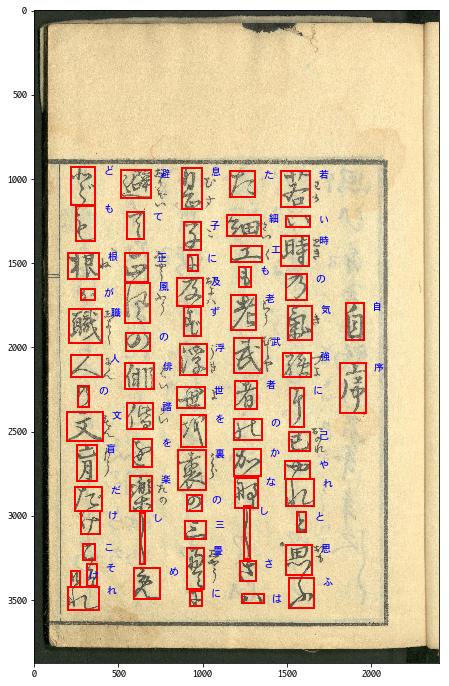

In [13]:
# One image example
figsize(12, 12)
plt.rc('font', family='Osaka')
one_pic = df_train[df_train.fname == df_train['fname'][0]]
for i in range(one_pic.shape[0]):
    im = read_image(df_train["fname"][i])
    bb = df_train[["bbox_y1", "bbox_x1",
                   "bbox_y2", "bbox_x2"]].values[i]
    char = labels_dict[df_train['Unicode_Char'][i]]
    show_corner_bb(im, bb, char)